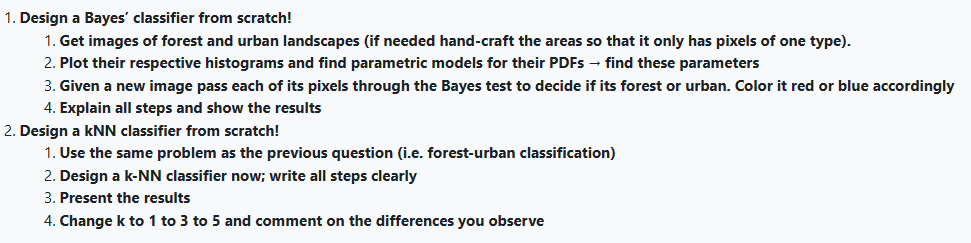

In [1]:
import glob
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Transformer
import scipy as sp
from scipy import optimize
from scipy import fftpack
import skopt as opt
from skimage.color import rgb2gray
from skimage.restoration import denoise_tv_chambolle
from scipy.fftpack import dct, idct
import os
from rasterio.windows import from_bounds, Window
import imageio.v2 as imageio
import math
from scipy.stats import norm, lognorm
from scipy.optimize import minimize

Forest and urban areas same as previously used (Strzelecki Park Krajobrazowy of Lubelskie Voivodeship and central Kraków area)

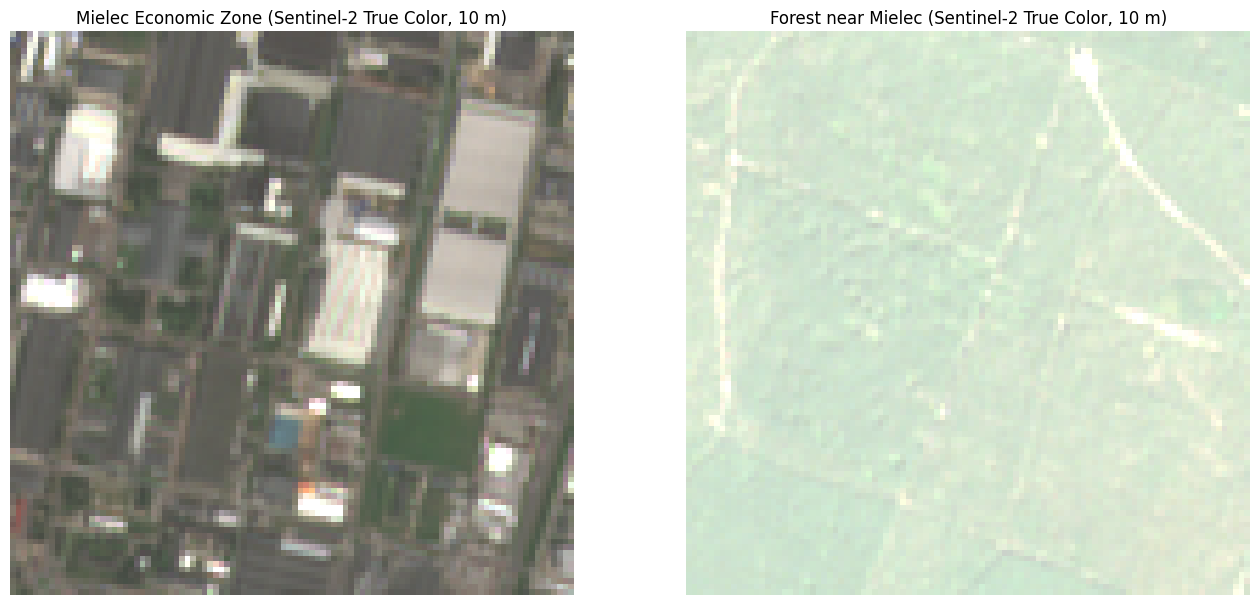

In [ ]:
# Paths to the 10m bands for both urban and rural areas
folder_m = "C:\\Users\\kacpe\\Desktop\\Studia\\ML\\S2A_MSIL2A_20250813T094041_N0511_R036_T34UEA_20250813T112012.SAFE\\GRANULE\\L2A_T34UEA_A052972_20250813T094043\\IMG_DATA\\R10m"
folder_fm = "C:\\Users\\kacpe\\Desktop\\Studia\\ML\\S2A_MSIL2A_20250813T094041_N0511_R036_T34UEA_20250813T112012.SAFE\\GRANULE\\L2A_T34UEA_A052972_20250813T094043\\IMG_DATA\\R10m"
# Paths to the r g and b bands 
band_paths_m = {b: glob.glob(f"{folder_m}/*_{b}_10m.jp2")[0] for b in ["B04", "B03", "B02"]}
band_paths_fm = {b: glob.glob(f"{folder_fm}/*_{b}_10m.jp2")[0] for b in ["B04", "B03", "B02"]}

lon_m, lat_m = 21.46570, 50.31010   # Mielec  Economic Zone coordinates
lon_fm, lat_fm = 21.55724, 50.28835   # Forest near Mielec coordinates

# Transforming the image coordinates from lat/lon to UTM, taking 0.5km x 0.5km area around the point
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32634", always_xy=True)
x_m, y_m = transformer.transform(lon_m, lat_m)
x_fm, y_fm = transformer.transform(lon_fm, lat_fm)
dx = 500  
dy = 500  
xmin_m, ymin_m, xmax_m, ymax_m = x_m - dx, y_m - dy, x_m + dx, y_m + dy
xmin_fm, ymin_fm, xmax_fm, ymax_fm = x_fm - dx, y_fm - dy, x_fm + dx, y_fm + dy

def read_crop(path, bounds):
    with rasterio.open(path) as src:
        window = from_bounds(*bounds, transform=src.transform)
        data = src.read(1, window=window)
    return data

scale = 1.0 / 10000.0
# Cropping and converting to surface reflectance
b4_crop_m = read_crop(band_paths_m["B04"], (xmin_m, ymin_m, xmax_m, ymax_m)).astype(np.float32) * scale  # R
b3_crop_m = read_crop(band_paths_m["B03"], (xmin_m, ymin_m, xmax_m, ymax_m)).astype(np.float32) * scale  # G
b2_crop_m = read_crop(band_paths_m["B02"], (xmin_m, ymin_m, xmax_m, ymax_m)).astype(np.float32) * scale  # B

b4_crop_fm = read_crop(band_paths_fm["B04"], (xmin_fm, ymin_fm, xmax_fm, ymax_fm)).astype(np.float32) * scale  # R
b3_crop_fm = read_crop(band_paths_fm["B03"], (xmin_fm, ymin_fm, xmax_fm, ymax_fm)).astype(np.float32) * scale  # G
b2_crop_fm = read_crop(band_paths_fm["B02"], (xmin_fm, ymin_fm, xmax_fm, ymax_fm)).astype(np.float32) * scale  # B


# Stack, normalize, remove outliers
cropped_rgb_m = np.dstack((b4_crop_m, b3_crop_m, b2_crop_m)).astype(np.float32)
cropped_rgb_m /= np.percentile(cropped_rgb_m, 99)
cropped_rgb_m = np.clip(cropped_rgb_m, 0, 1)

cropped_rgb_fm = np.dstack((b4_crop_fm, b3_crop_fm, b2_crop_fm)).astype(np.float32)
cropped_rgb_fm /= np.percentile(cropped_rgb_fm, 99)
cropped_rgb_fm = np.clip(cropped_rgb_fm, 0, 1)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[1].imshow(cropped_rgb_fm)
axs[1].set_title("Forest near Mielec (Sentinel-2 True Color, 10 m)")
axs[1].axis("off")
axs[0].imshow(cropped_rgb_m)
axs[0].set_title("Mielec Economic Zone (Sentinel-2 True Color, 10 m)")
axs[0].axis("off")
plt.show()

Histograms (code from slides)

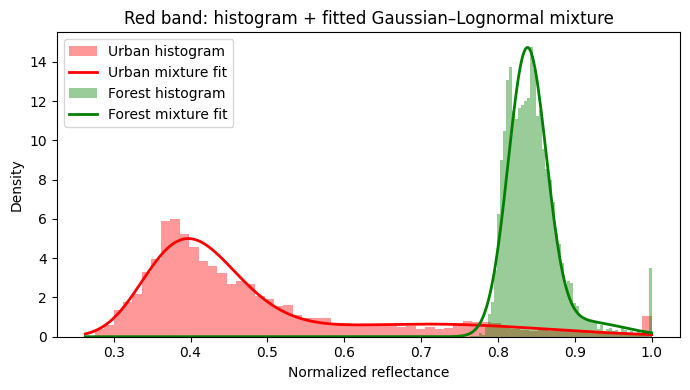


Red band parameters
Urban:  alpha=0.246, mu=0.710, sigma=0.153, m=-0.903, s=0.152
Forest: alpha=0.900, mu=0.838, sigma=0.025, m=-0.090, s=0.057


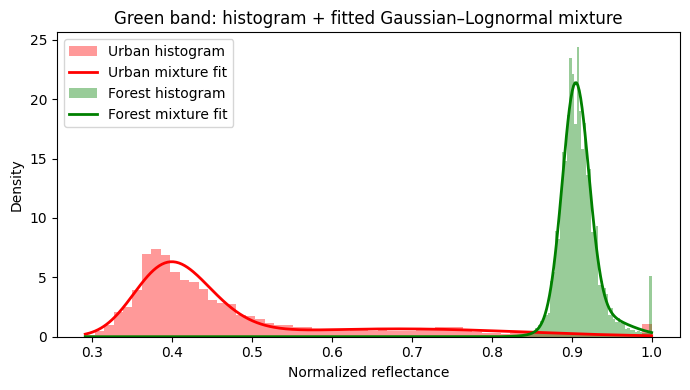


Green band parameters
Urban:  alpha=0.259, mu=0.683, sigma=0.157, m=-0.904, s=0.119
Forest: alpha=0.822, mu=0.905, sigma=0.017, m=-0.074, s=0.042


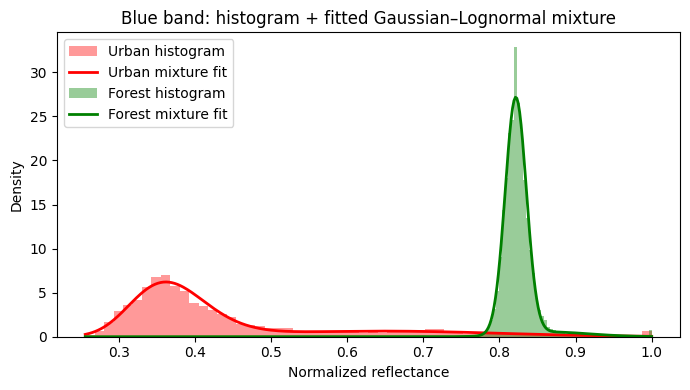


Blue band parameters
Urban:  alpha=0.246, mu=0.648, sigma=0.154, m=-1.000, s=0.135
Forest: alpha=0.934, mu=0.821, sigma=0.014, m=-0.139, s=0.057


In [ ]:
# mixture model functions
def mixture_pdf(x, alpha, mu, sigma, m, s):
    return alpha * norm.pdf(x, mu, sigma) + (1 - alpha) * lognorm.pdf(x, s, scale=np.exp(m))

def neg_log_likelihood(params, data):
    alpha, mu, sigma, m, s = params
    pdfs = mixture_pdf(data, alpha, mu, sigma, m, s)
    pdfs = np.maximum(pdfs, 1e-10)
    return -np.sum(np.log(pdfs))

# flatten the images 
urban_pixels  = cropped_rgb_m.reshape(-1, 3)
forest_pixels = cropped_rgb_fm.reshape(-1, 3)

band_names = ["Red", "Green", "Blue"]

params_urban = {}
params_forest = {}

for i, band in enumerate(band_names):
    plt.figure(figsize=(7,4))
    udata = urban_pixels[:, i]
    fdata = forest_pixels[:, i]

    # urban calc 
    init = [0.5, np.mean(udata), np.std(udata),
            np.mean(np.log(udata + 1e-6)), np.std(np.log(udata + 1e-6))]
    bounds = [(0,1), (None,None), (1e-3,None), (None,None), (1e-3,None)]
    result_u = minimize(neg_log_likelihood, init, args=(udata,), bounds=bounds)
    params_urban[band] = tuple(result_u.x)
    a_u, mu_u, sig_u, m_u, s_u = result_u.x

    # plot urban
    xs = np.linspace(udata.min(), udata.max(), 400)
    plt.hist(udata, bins=60, density=True, alpha=0.4, color='r', label='Urban histogram')
    plt.plot(xs, mixture_pdf(xs, a_u, mu_u, sig_u, m_u, s_u), 'r', lw=2, label='Urban mixture fit')

    # forest calc 
    init = [0.5, np.mean(fdata), np.std(fdata),
            np.mean(np.log(fdata + 1e-6)), np.std(np.log(fdata + 1e-6))]
    result_f = minimize(neg_log_likelihood, init, args=(fdata,), bounds=bounds)
    params_forest[band] = tuple(result_f.x)
    a_f, mu_f, sig_f, m_f, s_f = result_f.x

    plt.hist(fdata, bins=60, density=True, alpha=0.4, color='g', label='Forest histogram')
    plt.plot(xs, mixture_pdf(xs, a_f, mu_f, sig_f, m_f, s_f), 'g', lw=2, label='Forest mixture fit')

    plt.xlabel("Normalized reflectance")
    plt.ylabel("Density")
    plt.title(f"{band} band: histogram + fitted Gaussian–Lognormal mixture")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"\n{band} band parameters")
    print(f"Urban:  alpha={a_u:.3f}, mu={mu_u:.3f}, sigma={sig_u:.3f}, m={m_u:.3f}, s={s_u:.3f}")
    print(f"Forest: alpha={a_f:.3f}, mu={mu_f:.3f}, sigma={sig_f:.3f}, m={m_f:.3f}, s={s_f:.3f}")



The fitted lines look great, the difference between forest and urban area is very easy to see, with forest having higher normalized reflectance across all bands

## Bayes 
Now zoomed out image of Forest



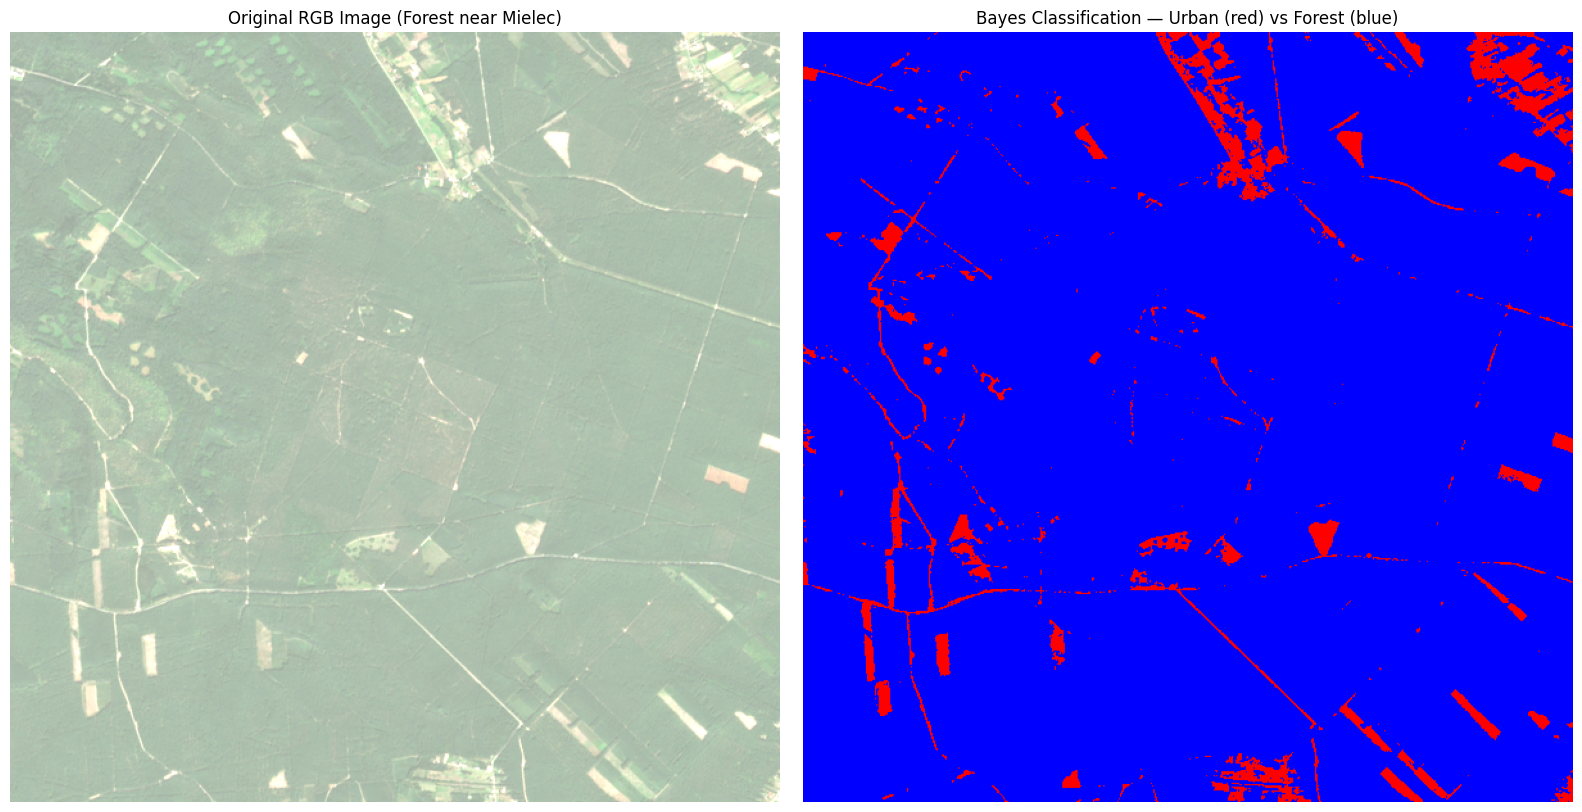

In [ ]:
# prep the image for classification
x_fm, y_fm = transformer.transform(lon_fm, lat_fm)
dx2 = 3000   
dy2 = 3000   
xmin_fm, ymin_fm, xmax_fm, ymax_fm = x_fm - dx2, y_fm - dy2, x_fm + dx2, y_fm + dy2
b4_crop_fm2 = read_crop(band_paths_fm["B04"], (xmin_fm, ymin_fm, xmax_fm, ymax_fm)).astype(np.float32) * scale  # R
b3_crop_fm2 = read_crop(band_paths_fm["B03"], (xmin_fm, ymin_fm, xmax_fm, ymax_fm)).astype(np.float32) * scale  # G
b2_crop_fm2 = read_crop(band_paths_fm["B02"], (xmin_fm, ymin_fm, xmax_fm, ymax_fm)).astype(np.float32) * scale  # B
cropped_rgb_fm2 = np.dstack((b4_crop_fm2, b3_crop_fm2, b2_crop_fm2)).astype(np.float32)
cropped_rgb_fm2 /= np.percentile(cropped_rgb_fm2, 99)
cropped_rgb_fm2 = np.clip(cropped_rgb_fm2, 0, 1)

def log_likelihood(rgb_img, params):
    eps = 1e-10
    ll = np.zeros(rgb_img.shape[:2], dtype=np.float32)
    for i, band in enumerate(["Red", "Green", "Blue"]):
        alpha, mu, sigma, m, s = params[band]
        band_vals = rgb_img[..., i]
        pdf = mixture_pdf(band_vals, alpha, mu, sigma, m, s)
        ll += np.log(np.maximum(pdf, eps))  # sum of log-likelihoods
    return ll

# compute
ll_forest = log_likelihood(cropped_rgb_fm2, params_forest)
ll_urban  = log_likelihood(cropped_rgb_fm2, params_urban)

# decision
pred_map = np.where(ll_urban > ll_forest, 0, 1)  # 0 = urban, 1 = forest


H, W = pred_map.shape
classified_rgb = np.zeros((H, W, 3), dtype=np.uint8)
classified_rgb[pred_map == 1] = [255, 0, 0]   # red = urban
classified_rgb[pred_map == 0] = [0, 0, 255]   # blue = forest

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(np.clip(cropped_rgb_fm2, 0, 1))
plt.title("Original RGB Image (Forest near Mielec)")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(classified_rgb)
plt.title("Bayes Classification — Urban (No forest) (red) vs Forest (blue)")
plt.axis("off")

plt.tight_layout()
plt.show()

Fields and urban infrastracture are put together which makes sense from the reflectance point of view.

## kNN

Same image. Should obtain similar results

Training samples: (2000, 3)
Running k-NN with k=1 ...
Running k-NN with k=3 ...
Running k-NN with k=5 ...


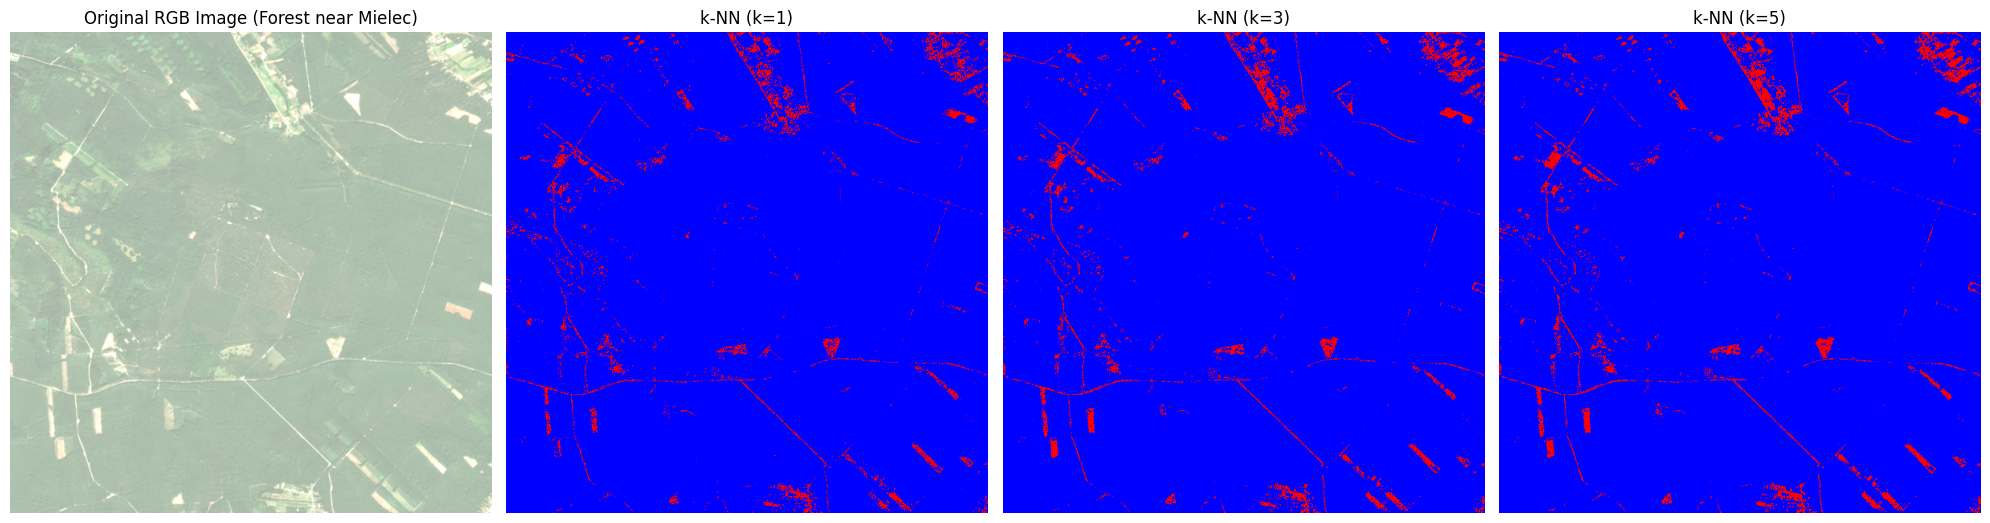

In [6]:
def to_training(rgb, label, n_samples):
    flat = rgb.reshape(-1, 3)
    n = min(n_samples, flat.shape[0])
    idx = np.random.default_rng(123).choice(flat.shape[0], size=n, replace=False)
    X = flat[idx]
    y = np.full(X.shape[0], label, dtype=np.uint8)
    return X, y

N_PER_CLASS = 1000
X_urban, y_urban = to_training(cropped_rgb_m, 0, N_PER_CLASS)   # 0 = urban (red)
X_forest, y_forest = to_training(cropped_rgb_fm, 1, N_PER_CLASS)  # 1 = forest (blue)
X_train = np.vstack([X_urban, X_forest]).astype(np.float32)
y_train = np.concatenate([y_urban, y_forest])
print("Training samples:", X_train.shape)

# flatten test image
H, W, _ = cropped_rgb_fm2.shape
X_test = cropped_rgb_fm2.reshape(-1, 3).astype(np.float32)

def knn_predict(X_train, y_train, X_test, k=3, chunk=2048):
    n_test = X_test.shape[0]
    y_pred = np.empty(n_test, dtype=np.uint8)
    for start in range(0, n_test, chunk):
        end = min(start + chunk, n_test)
        T = X_test[start:end]
        diffs = T[:, None, :] - X_train[None, :, :]
        d2 = np.sum(diffs * diffs, axis=2)
        nn_idx = np.argpartition(d2, kth=k-1, axis=1)[:, :k]
        nn_labels = y_train[nn_idx]
        votes_forest = np.sum(nn_labels == 1, axis=1)
        y_pred[start:end] = (votes_forest > (k // 2)).astype(np.uint8)
    return y_pred

# run for k = 1, 3, 5
pred_maps = {}
for k in (1, 3, 5):
    print(f"Running k-NN with k={k} ...")
    preds = knn_predict(X_train, y_train, X_test, k=k, chunk=1024)
    pred_maps[k] = preds.reshape(H, W)


fig, axes = plt.subplots(1, 4, figsize=(20, 8))
axes[0].imshow(np.clip(cropped_rgb_fm2, 0, 1))
axes[0].set_title("Original RGB Image (Forest near Mielec)")
axes[0].axis("off")

for i, k in enumerate([1, 3, 5], start=1):
    pred_map = pred_maps[k]
    classified_rgb = np.zeros((H, W, 3), dtype=np.uint8)
    classified_rgb[pred_map == 1] = [255, 0, 0] 
    classified_rgb[pred_map == 0] = [0, 0, 255] 

    axes[i].imshow(classified_rgb)
    axes[i].set_title(f"k-NN (k={k})")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


Higher K gives more uniform predictions especially on fields. I think Bayes in such case is better. Also I messed something up and colors had to be reversed (I don't know why and considering the date I don't want to even try to look for mistake). Leaving that behind I think in this case Bayes gave me better results.